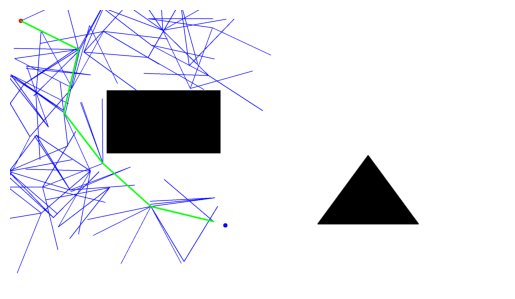

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import cv2

class point:
    x: int = None
    y: int = None

class Node:
    def __init__(self, data):
        self.data = data
        self.parent = None
        self.children = []

def calDist(p1, p2):
    return np.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)

def point_circle_collision(p1, p2, radius, map_img):
    distance = calDist(p1, p2)
    if distance <= radius:
        if set(map_img[p1.y, p1.x]) == set([0, 0, 0]):
            return True
    return False

def collision_with_obstacle(p1, p2, map_img, radius):
    map_gray = cv2.cvtColor(map_img, cv2.COLOR_RGB2GRAY)
    num_points_to_check = int(calDist(p1, p2) // radius)

    for i in range(num_points_to_check + 1):
        t = i / num_points_to_check
        x = int(p1.x * (1 - t) + p2.x * t)
        y = int(p1.y * (1 - t) + p2.y * t)

        if map_gray[y, x] < 255:
            return True

    return False

map_ori = cv2.imread('map.png')
map_ori = cv2.cvtColor(map_ori, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(map_ori)

q_start = point()
q_start.x, q_start.y = 50, 50
q_goal = point()
q_goal.x, q_goal.y = 1000, 1000

map = cv2.circle(map_ori.copy(), (q_start.x, q_start.y), 10, (255, 0, 0), -1)
map = cv2.circle(map, (q_goal.x, q_goal.y), 10, (0, 0, 255), -1)
tree = [Node(q_start)]  # Node 클래스 사용하여 초기화

# RRT Tree
for i in range(150):
    q_rand = point()
    q_rand.x, q_rand.y = np.random.randint(0, 1000), np.random.randint(0, 1000)
    q_near = tree[0]
    min_dist = calDist(q_rand, q_near.data)

    for node in tree:
        dist = calDist(q_rand, node.data)
        if dist < min_dist:
            min_dist = dist
            q_near = node

    gamma = 300
    theta = math.atan2(q_rand.y - q_near.data.y, q_rand.x - q_near.data.x)
    q_new = point()
    q_new.x = int(q_near.data.x + gamma * math.cos(theta))
    q_new.y = int(q_near.data.y + gamma * math.sin(theta))

    if point_circle_collision(q_new, q_near.data, 10, map_ori) or \
            collision_with_obstacle(q_near.data, q_new, map_ori, 10):
        continue

    # Node로 지정 -> parent, children
    q_new_node = Node(q_new)
    q_new_node.parent = q_near
    q_near.children.append(q_new_node)
    tree.append(q_new_node)
    # 이전 RRT
    map = cv2.line(map, (q_near.data.x, q_near.data.y), (q_new.x, q_new.y), (0, 0, 255), 2)

# q_new와 가장 가까운 점 표시
min_dist_goal = calDist(q_goal, tree[0].data)
q_goal_nearest = tree[0]

for node in tree:
    dist_goal = calDist(q_goal, node.data)
    if dist_goal < min_dist_goal:
        min_dist_goal = dist_goal
        q_goal_nearest = node

# qnew와 가장 가까운 노드 저장
optimal_path = []
current_node = q_goal_nearest

# current_node 추가 => 최적 노드 경로
while current_node is not None:
    optimal_path.append(current_node.data)
    # 노드에 parent 지정
    current_node = current_node.parent
    
# 초록색 표시
for i in range(len(optimal_path) - 1):
    q1 = optimal_path[i]
    q2 = optimal_path[i + 1]
    map = cv2.line(map, (q1.x, q1.y), (q2.x, q2.y), (0, 255, 0), 5)

plt.imshow(map)
plt.axis('off')
plt.show()

